In [2]:
# In this project, we use the solubility data from before and run CNN on images
# generated from rdkit.  These images are also tagged as being hydrophobic and
# hydrophilic. We then see if the CNN can correctly predict whether the structure
# is hydrophilic or hydrophobic based on the the drawing of the structure. 
#%%
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
device = torch.device('cuda:0')
import os
from google.colab import drive
drive.mount('/content/gdrive')   #mount at GFS
dirpath = '/content/gdrive/My Drive/Colab Notebooks/Msc Project/image1'

from tqdm import tqdm

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
images_arr = np.load(dirpath + '/im_tensor.npy')
labels_arr = np.load(dirpath + '/category_tensor.npy')

images_train, images_test, labels_train, labels_test = train_test_split(
    images_arr, labels_arr, test_size=0.2, random_state=25)

# torch requires images in the format (channels, height, width)
images_train = np.transpose(images_train, axes=(0, 3, 1, 2))
images_test = np.transpose(images_test, axes=(0, 3, 1, 2))

In [4]:
class imagesDataset(Dataset):

    def __init__(self, images, categories):

        super(imagesDataset, self).__init__()

        self.images = images
        self.categories = categories

    def __len__(self):
        # len() specifies the upper bound for the index of the dataset
        return len(self.categories)

    def __getitem__(self, index):
        # The generator executes the getitem() method to generate a sample
        return self.images[index], self.categories[index]


In [5]:
train_set = imagesDataset(images_train, labels_train)
test_set = imagesDataset(images_test, labels_test)

batch_size = 25
train_generator = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_generator = DataLoader(test_set, batch_size=batch_size, shuffle=True)


In [6]:
# Next we define the CNN we want to use

class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(4, 32, (3, 3))
        self.conv2 = nn.Conv2d(32, 64, (3, 3))

        self.fc1 = nn.Linear(104*104*64, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)

        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2)
        self.logsoftmax = nn.LogSoftmax(dim=0)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)

        x = x.view(-1, 104*104*64)

        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        x = self.logsoftmax(x)

        return x
    
    # def length(self, x):
    #     linearized = x.view(4, 1, -1)
    #     return linearized.shape[0]

In [34]:
NUM_EPOCHS = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn = CNN().to(device)

objective = nn.NLLLoss()
optimizer = optim.SGD(cnn.parameters(), lr=.00001)



100%|██████████| 37/37 [03:30<00:00,  5.69s/it]

  0%|          | 0/37 [00:00<?, ?it/s]

Loss for Epoch 0 = tensor(0.1573)



100%|██████████| 37/37 [03:27<00:00,  5.60s/it]

Loss for Epoch 1 = tensor(0.1542)
Finished Training
Training time: 417.66417026519775


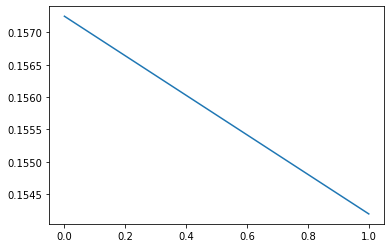

In [35]:
total_loss = torch.zeros(NUM_EPOCHS)
import time
start_training = time.time()
for i in range(NUM_EPOCHS):
    for inp, labels in tqdm(train_generator):
        inp, label = inp.float().to(device), labels.float().to(device)
        out = cnn(inp)

        optimizer.zero_grad()
        # The reshaping is because pytorch needs these dimensions for 
        # NLLLoss to work properly. 
        loss = objective(out.squeeze(1), label.long().view(-1))
        loss.backward()
        optimizer.step()
        total_loss[i] += loss.item()/(.8*len(train_generator)*batch_size)
    print('Loss for Epoch', i, '=', total_loss[i])

print("Finished Training")
end_training = time.time()
print('Training time:',end_training-start_training)
plt.plot(range(total_loss.shape[0]), total_loss)



100%|██████████| 10/10 [00:54<00:00,  5.43s/it]

Loss for Epoch 1 = tensor(0.2794)
Finish Testing
Test time: 54.33452892303467


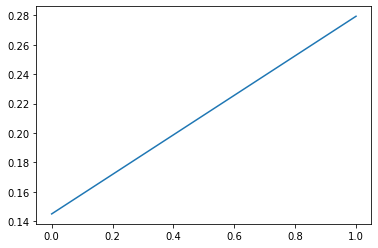

In [21]:

start_test = time.time()

for inp, labels in tqdm(test_generator):
        inp, label = inp.float().to(device), labels.float().to(device)
        out = cnn(inp)

        _, predicted = torch.max(out.data, 1)
        loss = objective(out.squeeze(1), label.long().view(-1))
        loss.backward()
        total_loss[i] += loss.item()/(.8*len(test_generator)*batch_size)
print('Loss for Epoch', i, '=', total_loss[i])
print("Finish Testing")
end_test = time.time()
print('Test time:',end_test-start_test)
plt.plot(range(total_loss.shape[0]), total_loss)

In [12]:
f = dirpath + 'cnn_saved.pt'
torch.save(cnn.state_dict(), f)
#%%
f = dirpath + 'cnn_saved.pt'
cnn = CNN()
cnn.load_state_dict(torch.load(f))
cnn.eval()
cnn.to(device)


CNN(
  (conv1): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=692224, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (logsoftmax): LogSoftmax(dim=0)
)

tensor([1])
tensor([0.])
Soluble


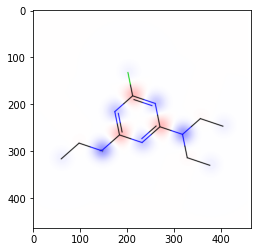

In [23]:
from PIL import Image
images1 = Image.open(dirpath + '/figs/mol66.png')
plt.imshow(images1)
preds1 = torch.argmax(cnn(inp.float().to(device)), dim=1)

print(preds1)
labels = label.to(device).view(-1)
print(labels)
if preds1.item() == 1:
  print('Soluble')
else:
  print('Insoluble')


In [32]:

def validation():
    errors = 0
    labels_cm = np.array([])
    predicted_cm = np.array([]) 
    for inp, label in tqdm(test_generator):
        preds = torch.argmax(cnn(inp.float().to(device)), dim=1)
        print(preds)
        labels = label.to(device).view(-1)
        print(labels)
        stacked = torch.stack((labels,preds),dim=1)
        print(stacked)
        cmt = torch.zeros(2,2, dtype=torch.int64)
        for p in stacked:
          tl, pl = p.tolist()
          cmt[tl, pl] = cmt[tl, pl] + 1
        plot_confusion_matrix(cmt,[0,1])
        errors += torch.sum((preds==labels)*1).item()
        print(errors)
    return errors*100/(len(test_generator)*batch_size)

In [31]:
preds = torch.argmax(cnn(inp.float().to(device)), dim=1)

labels = label.to(device).view(-1)

print(labels)
print(preds)
stacked = torch.stack((labels,preds),dim=1)
print(stacked)
cmt = torch.zeros(2,2, dtype=torch.int64)
for p in stacked:
    tl, pl = p.tolist()
    cmt[tl, pl] = cmt[tl, pl] + 1
cmt



tensor([1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1,
        1], dtype=torch.int32)
tensor([0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1,
        0])
tensor([[1, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 1],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 0]])


tensor([[7, 5],
        [5, 8]])

In [24]:
import itertools

def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix very prettily.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    # Specify the tick marks and axis text
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    # The data formatting
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Print the text of the matrix, adjusting text colour for display
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

Confusion matrix, without normalization


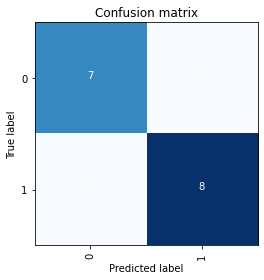

In [29]:
plot_confusion_matrix(cmt,[0,1])


  0%|          | 0/10 [00:00<?, ?it/s]

tensor([1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
        0])
tensor([1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
        0], dtype=torch.int32)
tensor([[1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 0],
        [0, 0],
        [1, 0],
        [1, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 0],
        [0, 0]])
Confusion matrix, without normalization


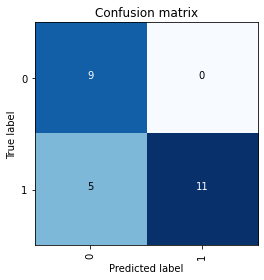


 10%|█         | 1/10 [00:05<00:45,  5.02s/it]

20
tensor([0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1,
        0])
tensor([0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
        0], dtype=torch.int32)
tensor([[0, 0],
        [1, 1],
        [0, 0],
        [1, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 1],
        [1, 1],
        [1, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 0],
        [1, 0],
        [0, 0],
        [0, 1],
        [1, 1],
        [0, 0]])
Confusion matrix, without normalization


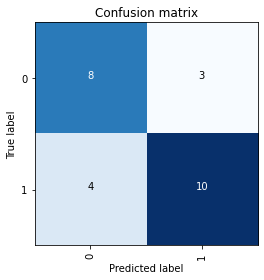


 20%|██        | 2/10 [00:07<00:34,  4.37s/it]

38
tensor([1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
        0])
tensor([1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0,
        0], dtype=torch.int32)
tensor([[1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 0],
        [1, 1],
        [1, 1],
        [0, 1],
        [1, 1],
        [0, 1],
        [1, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 1],
        [0, 0]])
Confusion matrix, without normalization


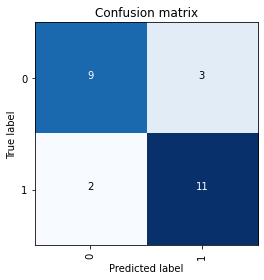


 30%|███       | 3/10 [00:10<00:27,  3.92s/it]

58
tensor([1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0,
        0])
tensor([1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0,
        1], dtype=torch.int32)
tensor([[1, 1],
        [1, 1],
        [0, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 1],
        [0, 0],
        [1, 1],
        [0, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 0]])
Confusion matrix, without normalization


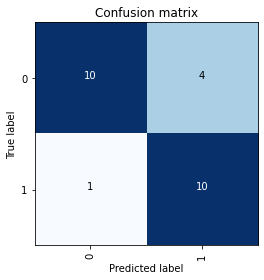


 40%|████      | 4/10 [00:13<00:21,  3.58s/it]

78
tensor([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,
        0])
tensor([0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
        0], dtype=torch.int32)
tensor([[0, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 0],
        [1, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 0],
        [0, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0]])
Confusion matrix, without normalization


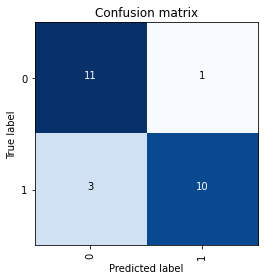


 50%|█████     | 5/10 [00:16<00:16,  3.33s/it]

99
tensor([1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
        1])
tensor([1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
        0], dtype=torch.int32)
tensor([[1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 1],
        [0, 1],
        [1, 1],
        [0, 0],
        [1, 0],
        [1, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 0],
        [1, 1],
        [0, 1],
        [0, 1]])
Confusion matrix, without normalization


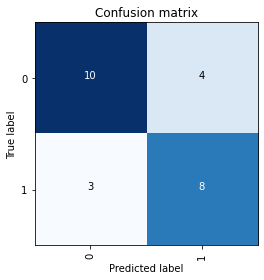


 60%|██████    | 6/10 [00:19<00:12,  3.18s/it]

117
tensor([1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1,
        0])
tensor([1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
        0], dtype=torch.int32)
tensor([[1, 1],
        [0, 1],
        [0, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 0],
        [1, 1],
        [0, 1],
        [1, 1],
        [1, 0],
        [0, 1],
        [0, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 1],
        [0, 1],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0]])
Confusion matrix, without normalization


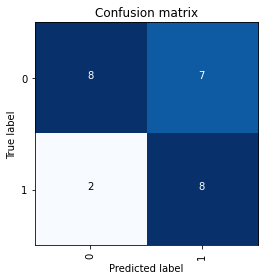


 70%|███████   | 7/10 [00:21<00:09,  3.08s/it]

133
tensor([0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1,
        1])
tensor([0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
        1], dtype=torch.int32)
tensor([[0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 1],
        [1, 0],
        [1, 1],
        [1, 1],
        [1, 0],
        [0, 0],
        [1, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 0],
        [1, 1],
        [1, 0],
        [0, 0],
        [0, 0],
        [0, 1],
        [1, 1]])
Confusion matrix, without normalization


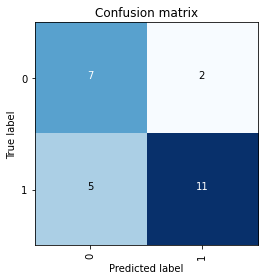


 80%|████████  | 8/10 [00:24<00:05,  3.00s/it]

151
tensor([0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
        0])
tensor([0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0,
        1], dtype=torch.int32)
tensor([[0, 0],
        [0, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 1],
        [0, 0],
        [1, 1],
        [0, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 0],
        [0, 1],
        [0, 0],
        [1, 0]])
Confusion matrix, without normalization


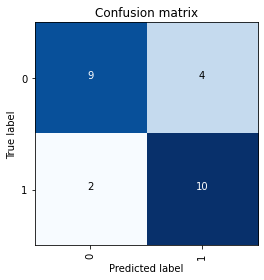


 90%|█████████ | 9/10 [00:27<00:02,  2.95s/it]

170
tensor([1])
tensor([0], dtype=torch.int32)
tensor([[0, 1]])
Confusion matrix, without normalization


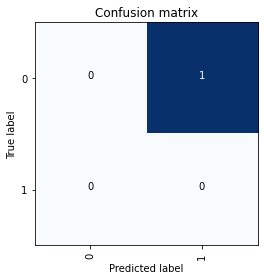


100%|██████████| 10/10 [00:27<00:00,  2.79s/it]

170
/n
accuracy: 68.0 %


In [33]:
accuracy = validation()

print('/n')
print('accuracy:', accuracy, '%')